In [1]:
import plotly.io as pio
pio.renderers.default = "notebook+pdf"

In [4]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

In [7]:
from catboost import CatBoostClassifier
from catboost import Pool

def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1000,
        use_best_model= True,
        #task_type='GPU'
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [9]:
df=pd.read_csv("./Data/kag_risk_factors_cervical_cancer.csv")
df.head()

Age Number of sexual partners First sexual intercourse Num of pregnancies  \
0   18                       4.0                     15.0                1.0   
1   15                       1.0                     14.0                1.0   
2   34                       1.0                        ?                1.0   
3   52                       5.0                     16.0                4.0   
4   46                       3.0                     21.0                4.0   

  Smokes Smokes (years) Smokes (packs/year) Hormonal Contraceptives  \
0    0.0            0.0                 0.0                     0.0   
1    0.0            0.0                 0.0                     0.0   
2    0.0            0.0                 0.0                     0.0   
3    1.0           37.0                37.0                     1.0   
4    0.0            0.0                 0.0                     1.0   

  Hormonal Contraceptives (years)  IUD  ... STDs: Time since first diagnosis  \
0                             0.0  0.0  ...                                ?   
1                             0.0  0.0  ...                                ?   
2                             0.0  0.0  ...                                ?   
3                             3.0  0.0  ...                                ?   
4                            15.0  0.0  ...                                ?   

  STDs: Time since last diagnosis Dx:Cancer Dx:CIN Dx:HPV Dx Hinselmann  \
0                               ?         0      0      0  0          0   
1                               ?         0      0      0  0          0   
2                               ?         0      0      0  0          0   
3                               ?         1      0      1  0          0   
4                               ?         0      0      0  0          0   

  Schiller Citology Biopsy  
0        0        0      0  
1        0        0      0  
2        0        0      0  
3        0        0      0  
4        0        0      0  

[5 rows x 36 columns]

In [10]:
target = 'Biopsy'

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

Remove duplicates

In [12]:
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 835 non-null    int64 
 1   Number of sexual partners           835 non-null    object
 2   First sexual intercourse            835 non-null    object
 3   Num of pregnancies                  835 non-null    object
 4   Smokes                              835 non-null    object
 5   Smokes (years)                      835 non-null    object
 6   Smokes (packs/year)                 835 non-null    object
 7   Hormonal Contraceptives             835 non-null    object
 8   Hormonal Contraceptives (years)     835 non-null    object
 9   IUD                                 835 non-null    object
 10  IUD (years)                         835 non-null    object
 11  STDs                                835 non-null    object

# Preprocessing

Replace "?" with the median for all columns.

In [13]:
df = df.replace('?', np.nan)

print("Check all Nan counts")
df.isnull().sum()

Check all Nan counts


Age                                     0
Number of sexual partners              25
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               103
Hormonal Contraceptives (years)       103
IUD                                   112
IUD (years)                           112
STDs                                  100
STDs (number)                         100
STDs:condylomatosis                   100
STDs:cervical condylomatosis          100
STDs:vaginal condylomatosis           100
STDs:vulvo-perineal condylomatosis    100
STDs:syphilis                         100
STDs:pelvic inflammatory disease      100
STDs:genital herpes                   100
STDs:molluscum contagiosum            100
STDs:AIDS                             100
STDs:HIV                              100
STDs:Hepatitis B                  

In [14]:
df=df._convert(numeric=True)
df = df.fillna(df.median())

print("Check all Nan counts")
df.isnull().sum()

Check all Nan counts


Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


Other tasks
- Since Hinselmann, Schiller, Citology, Biopsy are all cancer test, create an aggreated group that count all of these information.
- Try to create an aggregated STD column that count all STD prediction
- Create an column for age group for easy visualization

In [15]:
#Create age group for visualization
def age_group(n):
    if n < 12:
        return "Child"
    elif n < 20:
        return "Teen"
    elif n < 30:
        return "20's"
    elif n < 40:
        return "30's"
    elif n < 50:
        return "40's"
    elif n < 60:
        return "50's"
    elif n < 70:
        return "60's"
    else:
        return "70+"

df["age_cat"] = df["Age"].apply(age_group)

In [16]:
#Aggregated std
std_cols = ['STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV']
df["total_std"] = df[list(std_cols)].sum(axis=1)
std_agg_df = df.groupby("age_cat", as_index=False)[list(std_cols)].sum()

In [17]:
#Aggregated test result:
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
df["total_tests"] = df[test_cols].sum(axis = 1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 857
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 835 non-null    int64  
 1   Number of sexual partners           835 non-null    float64
 2   First sexual intercourse            835 non-null    float64
 3   Num of pregnancies                  835 non-null    float64
 4   Smokes                              835 non-null    float64
 5   Smokes (years)                      835 non-null    float64
 6   Smokes (packs/year)                 835 non-null    float64
 7   Hormonal Contraceptives             835 non-null    float64
 8   Hormonal Contraceptives (years)     835 non-null    float64
 9   IUD                                 835 non-null    float64
 10  IUD (years)                         835 non-null    float64
 11  STDs                                835 non-n

# Data Exploration

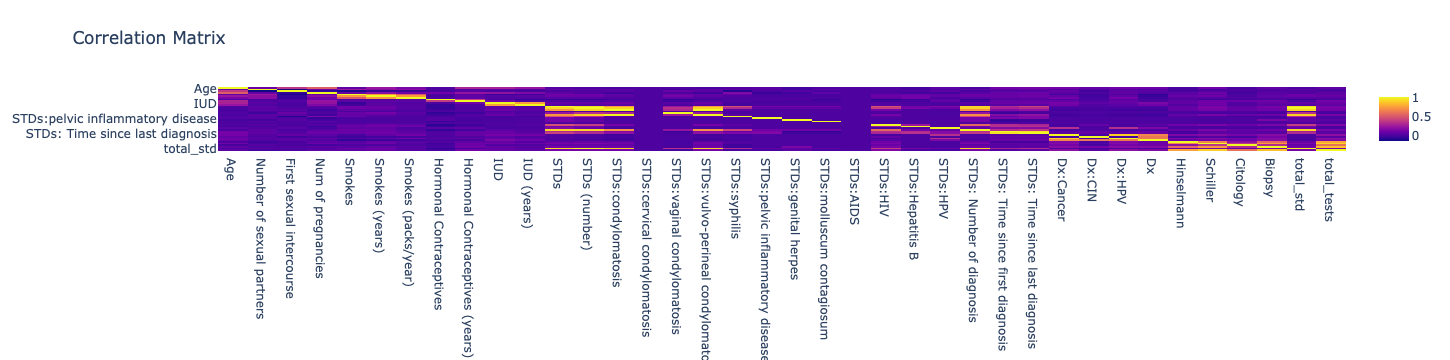

In [19]:
corr_matrix = df.corr()
corr_matrix.fillna(0,inplace=True)
corr_graph = px.imshow(corr_matrix, aspect="auto",title="Correlation Matrix")
corr_graph.show()

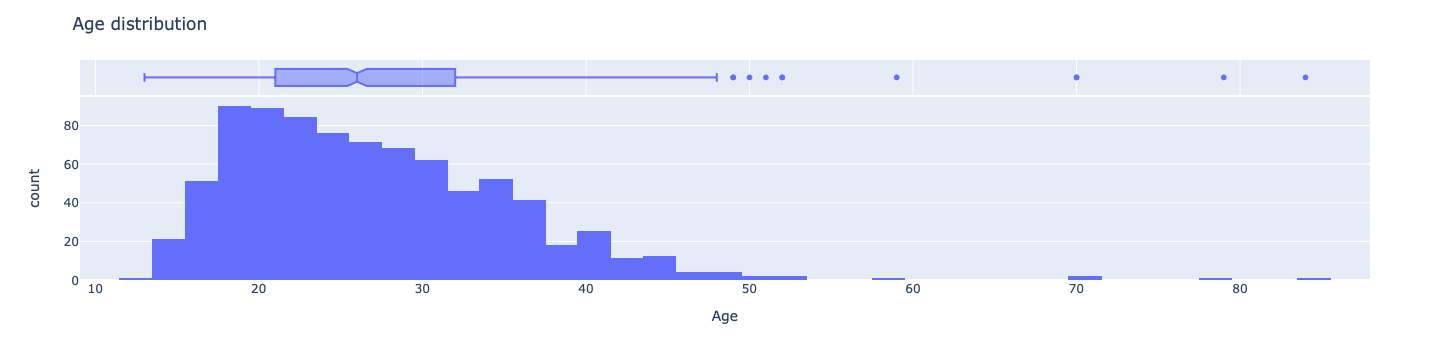

In [20]:
age_dist = px.histogram(df, x="Age", marginal="box")
age_dist.update_layout(title="Age distribution")
age_dist.show()

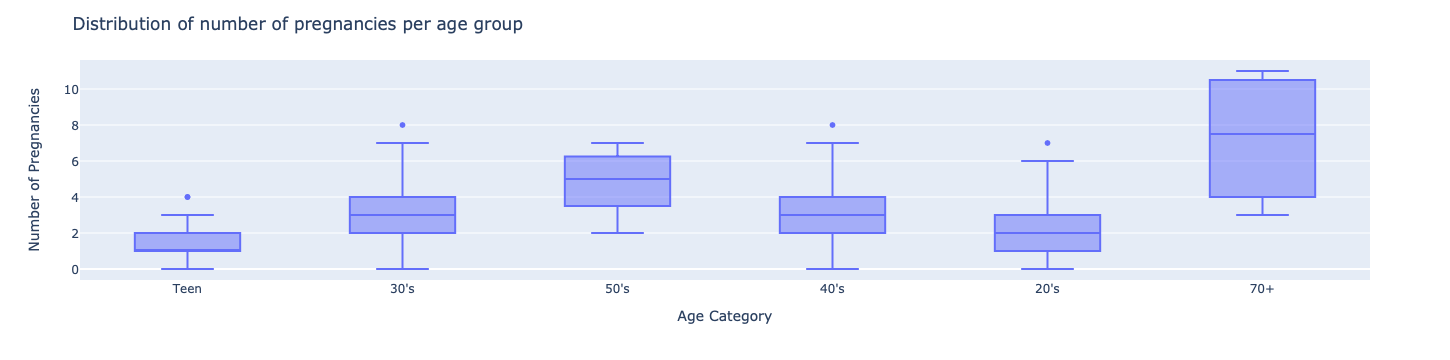

In [21]:
age_preg_bar = px.box(df, x="age_cat", y="Num of pregnancies", points="outliers",
                      category_orders=["Teenager", "Twenties", "Thirties", "Forties", "Fifties",
                                       "Seventy and over"])
age_preg_bar.update_xaxes(title="Age Category")
age_preg_bar.update_yaxes(title="Number of Pregnancies")
age_preg_bar.update_layout(title="Distribution of number of pregnancies per age group")
age_preg_bar.show()

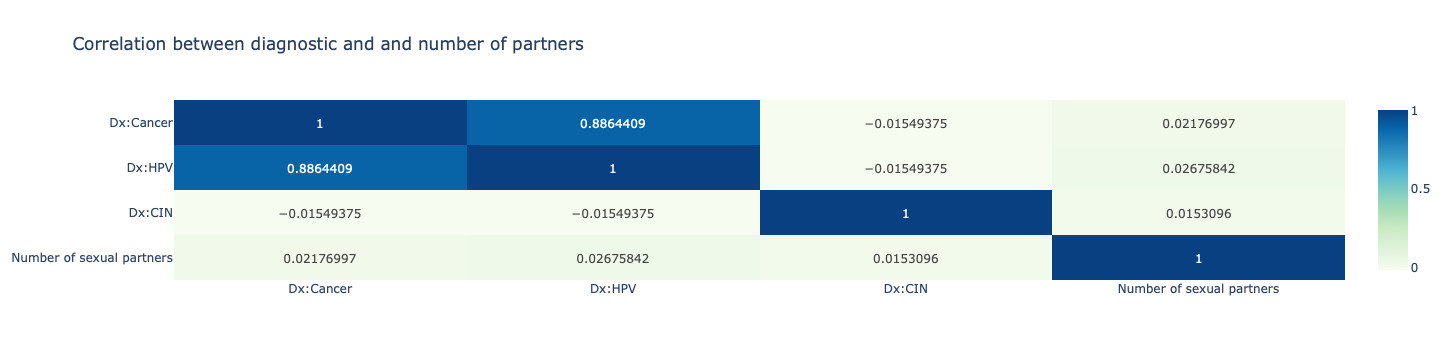

In [22]:
diagnoses_num_partner_compare_cols = ['Dx:Cancer',
                                      'Dx:HPV',
                                      'Dx:CIN',
                                      "Number of sexual partners",]
corr_matrix = df[diagnoses_num_partner_compare_cols].corr()
diagnoses_num_partner_heatmap = px.imshow(corr_matrix,
                              aspect="auto",
                              text_auto=True,
                                         title='Correlation between diagnostic and and number of partners',
                                         color_continuous_scale="gnbu")
diagnoses_num_partner_heatmap.show()

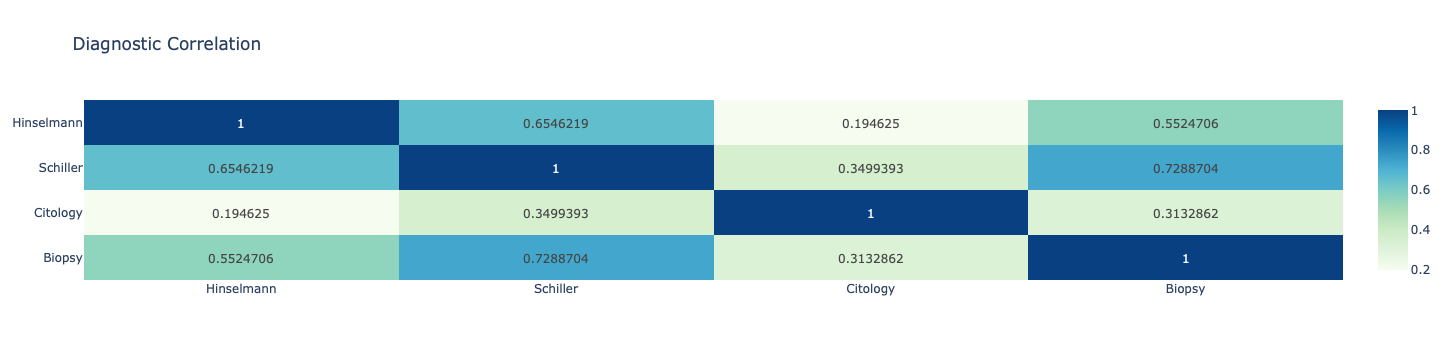

In [23]:
diagnoses_cols = ['Hinselmann','Schiller','Citology','Biopsy']
diagnoses_corr_matrix = df[diagnoses_cols].corr()
diagnoses_heatmap = px.imshow(diagnoses_corr_matrix, aspect="auto", text_auto=True,color_continuous_scale="gnbu",
                              title='Diagnostic Correlation')
diagnoses_heatmap.show()

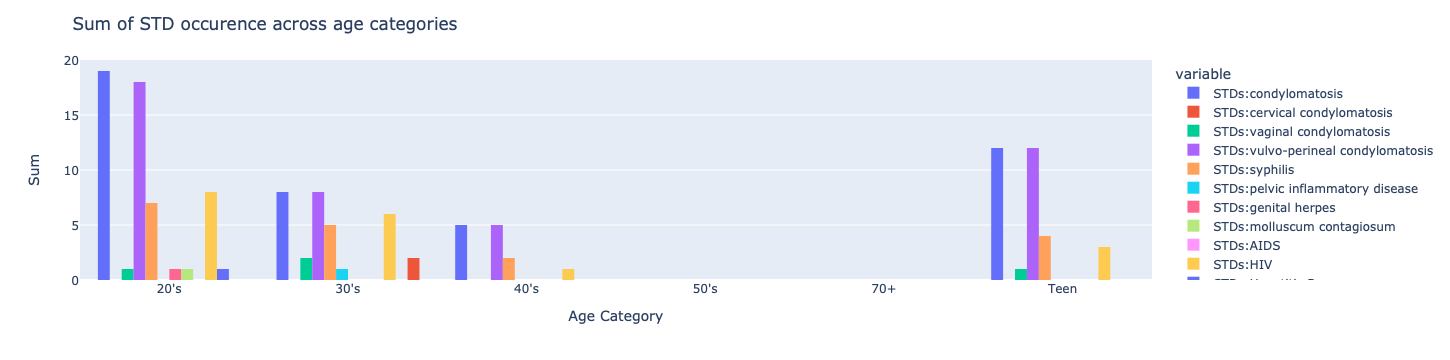

In [24]:
fig = px.histogram(std_agg_df, x="age_cat", y=list(std_cols), barmode="group", histfunc="sum")
fig.update_layout(title="Sum of STD occurence across age categories")
fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Sum")
fig.show()

# Distribution of Classes

In [25]:
df[target].value_counts()

0    781
1     54
Name: Biopsy, dtype: int64

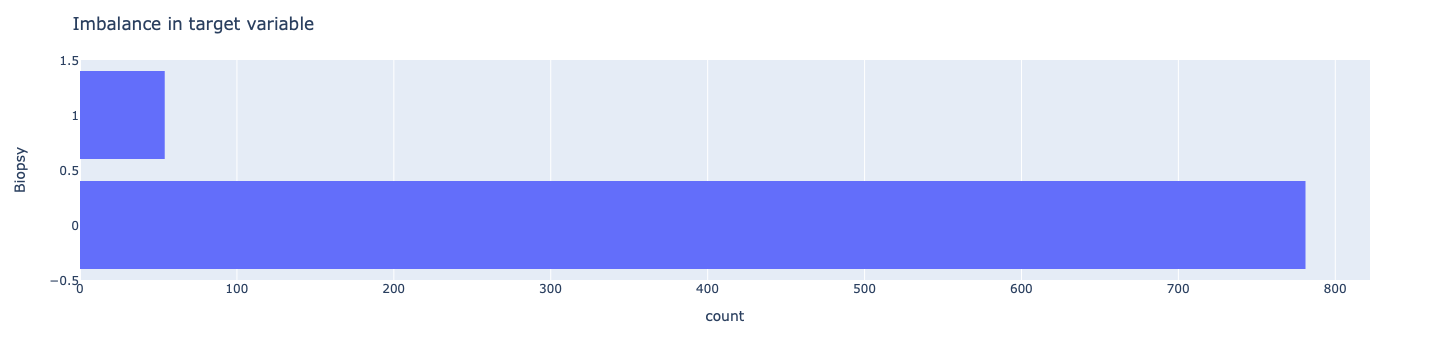

In [26]:
dx_cancer = px.histogram(df, y=target)
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Imbalance in target variable")
dx_cancer.show()

# SMOTE or ADASYN:
- Since we have a issues of imbalance data set, either Smote or Adasyn can be deployed to create synthetic data to balance the dataset
- ADASYN is used for now

In [27]:
X = df.drop([target, "age_cat"], axis=1)
y = df[target].copy()

In [28]:
# smote = SMOTE(random_state=42)
# x_smote, y_smote = smote.fit_resample(X, y)
# risk_factor_df = x_smote.join(y_smote)
# risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [29]:
adasyn = ADASYN(random_state=42)
X,y = adasyn.fit_resample(X,y)

# Train - test split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify = y, shuffle=True)#stratify = y

In [31]:
y_train.value_counts()

1    526
0    523
Name: Biopsy, dtype: int64

# PCA
- Principal Component Analysis is a method to reduce the dimenstion of larger dataset. This is used to increase performace. In this case 13 parameters can be used to explained 99% of the variable


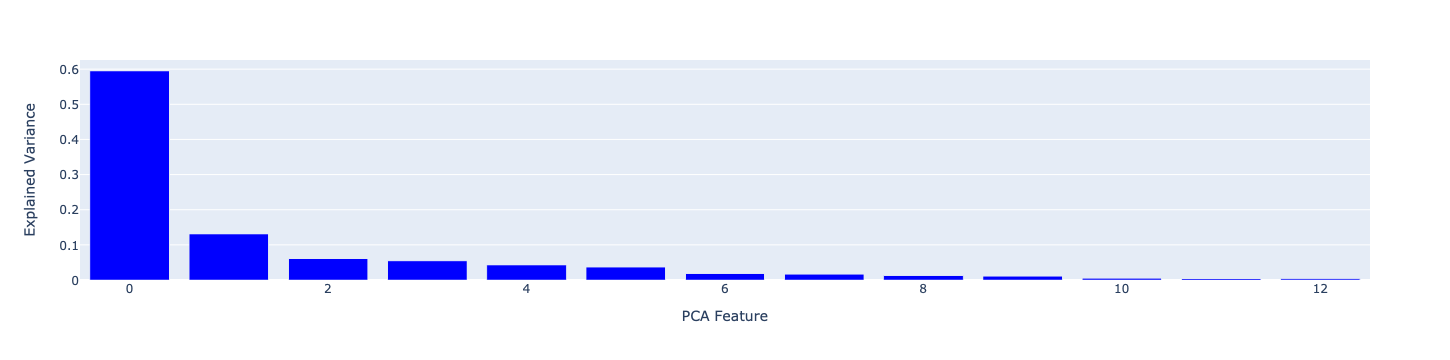

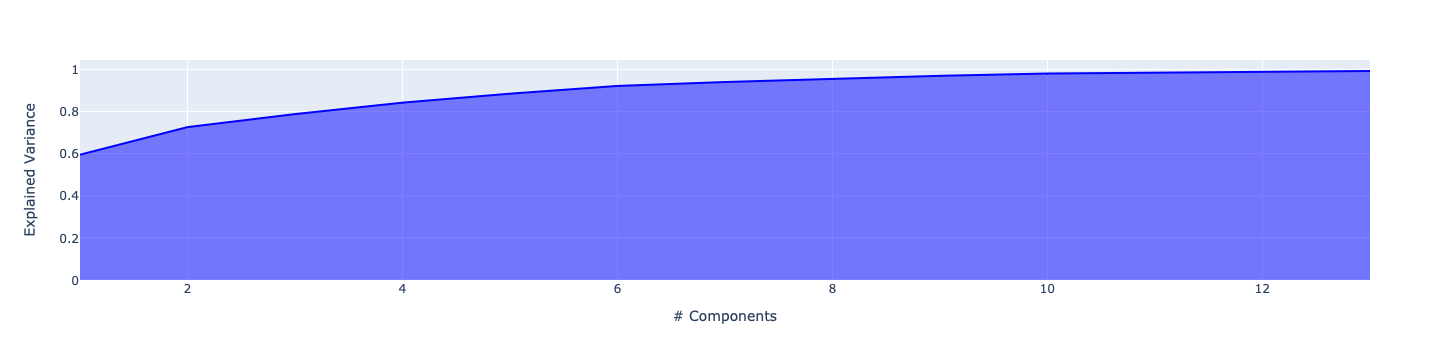

In [32]:
XT = RobustScaler().fit_transform(X_train)
pca = PCA(n_components=0.99)
XT = pca.fit_transform(XT)

dimensions = px.bar(x=range(pca.n_components_), y=pca.explained_variance_ratio_,
                    color_discrete_sequence=["blue"],
                    labels={"x":"PCA Feature","y":"Explained Variance"})
dimensions.show()
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

explained_variance = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    color_discrete_sequence=["blue"]
)
explained_variance.show()

# Model Application SkLearn
- 5 models are considered for this project
    - Logistic Regression
    - Random forest Classifier
    - KNeighbor Classifier
    - Support Vector Machine
    - CatBoost

In [33]:
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=13))
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [34]:
param_grid = {'C': np.logspace(-5, 8, 15)}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

In [35]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=2, n_jobs=-1,
                                 max_features="sqrt")

In [36]:
knn_clf = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 10, 2))}
knn_clf_cv = GridSearchCV(knn_clf, knn_param_grid, cv=10)

In [37]:
svm_clf = SVC()
svc_param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), }
svm_clf_cv = GridSearchCV(svm_clf, svc_param_grid, cv=5)

In [38]:
train_pool_CatBoost=Pool(X_train, y_train)
validation_pool_CatBoost = Pool(X_test, y_test)
cat_boost_model_done = fit_model(train_pool_CatBoost, validation_pool_CatBoost)

Learning rate set to 0.032066
0:	learn: 0.6536514	test: 0.6575531	best: 0.6575531 (0)	total: 48.4ms	remaining: 48.4s
100:	learn: 0.0658441	test: 0.1201070	best: 0.1201070 (100)	total: 147ms	remaining: 1.31s
200:	learn: 0.0291065	test: 0.0937748	best: 0.0937189 (199)	total: 204ms	remaining: 809ms
300:	learn: 0.0141980	test: 0.0847341	best: 0.0847341 (300)	total: 259ms	remaining: 601ms
400:	learn: 0.0083340	test: 0.0831227	best: 0.0827455 (366)	total: 313ms	remaining: 468ms
500:	learn: 0.0056603	test: 0.0837644	best: 0.0827455 (366)	total: 367ms	remaining: 366ms
600:	learn: 0.0042436	test: 0.0849377	best: 0.0827455 (366)	total: 423ms	remaining: 281ms
700:	learn: 0.0034095	test: 0.0855870	best: 0.0827455 (366)	total: 477ms	remaining: 204ms
800:	learn: 0.0028566	test: 0.0866545	best: 0.0827455 (366)	total: 530ms	remaining: 132ms
900:	learn: 0.0026247	test: 0.0873339	best: 0.0827455 (366)	total: 582ms	remaining: 63.9ms
999:	learn: 0.0023691	test: 0.0878066	best: 0.0827455 (366)	total: 635ms

In [39]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []

estimators = [
    ("LogisticRegression", logreg_cv),
    ("RandomForestClassifier ", rnd_clf),
    ("KNeighborsClassifier", knn_clf_cv),
    ("SupportVectorClassifier", svm_clf_cv),
    ("CatBoost",cat_boost_model_done)]

for i in range(0, len(estimators)):
    clf_name = estimators[i][0]
    clf = estimators[i][1]
    if clf_name!="CatBoost":
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(pd.crosstab(y_test,y_pred,rownames=["Actual"],colnames=["predicted"],margins=True))
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))


summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score


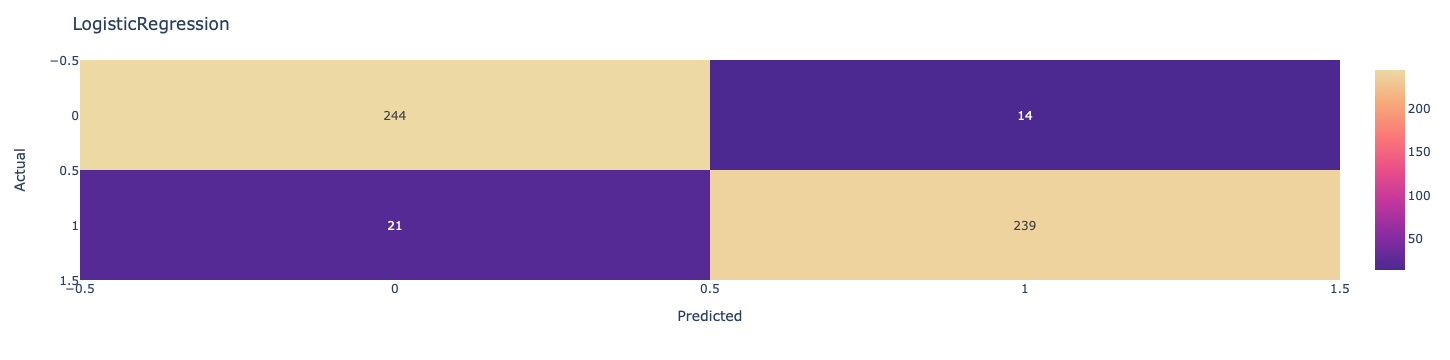

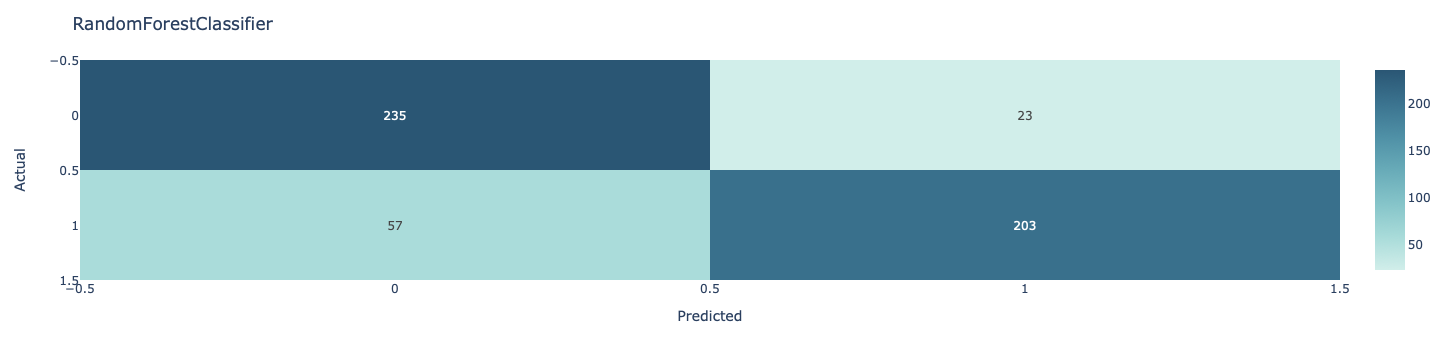

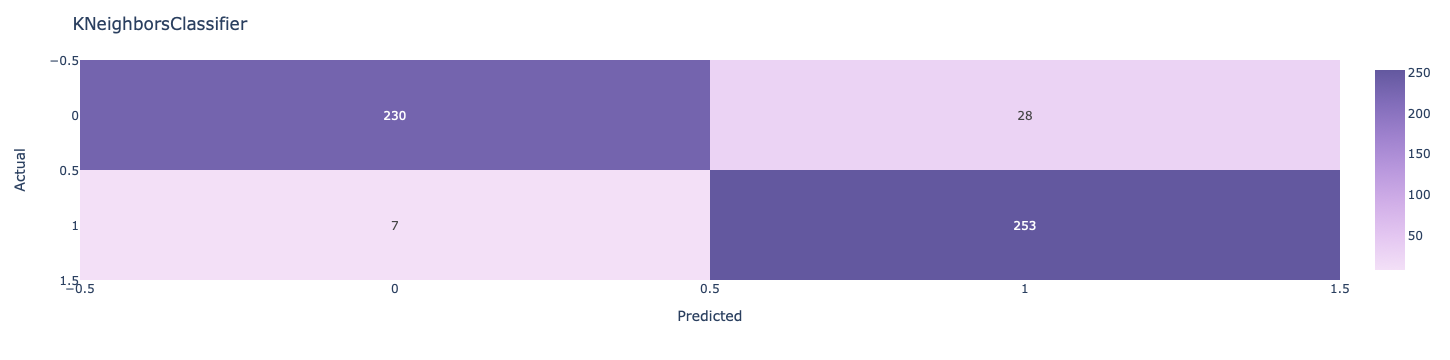

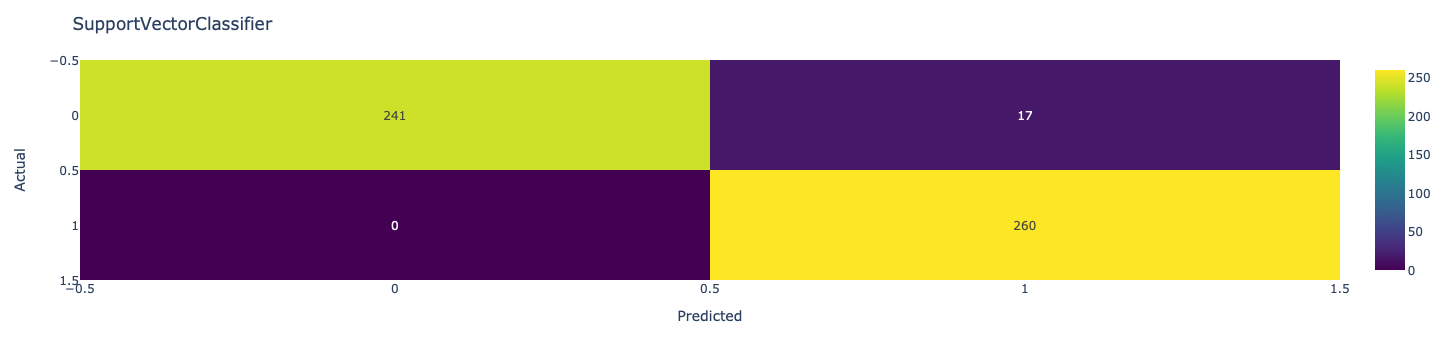

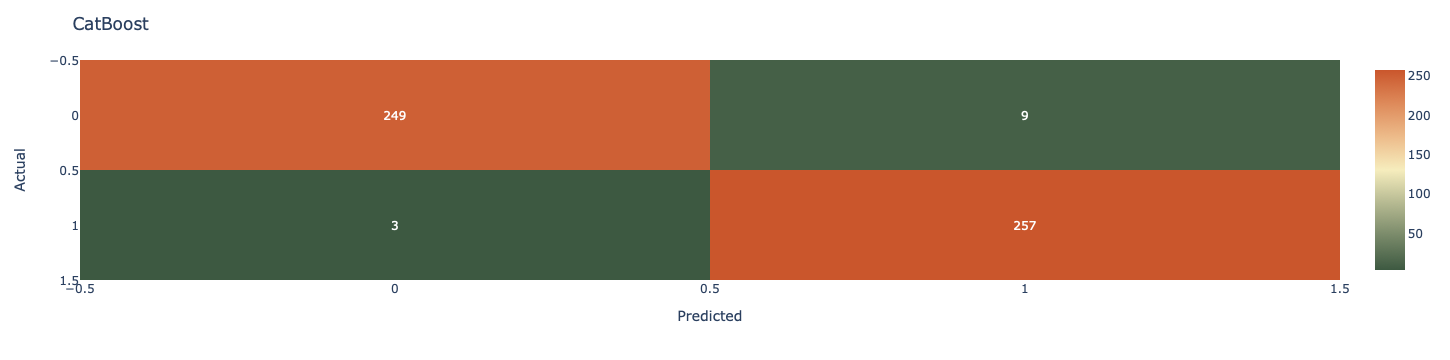

In [40]:
color_scales = ["agsunset","teal","purp","viridis","fall"]
for i in range(0,len(est_conf_matrix)):
    heatmap = px.imshow(est_conf_matrix[i],aspect="auto",
                        text_auto=True,
                        color_continuous_scale=color_scales[i])
    heatmap.update_layout(title = est_name[i])
    heatmap.update_xaxes(title="Predicted")
    heatmap.update_yaxes(title="Actual")
    heatmap.show()

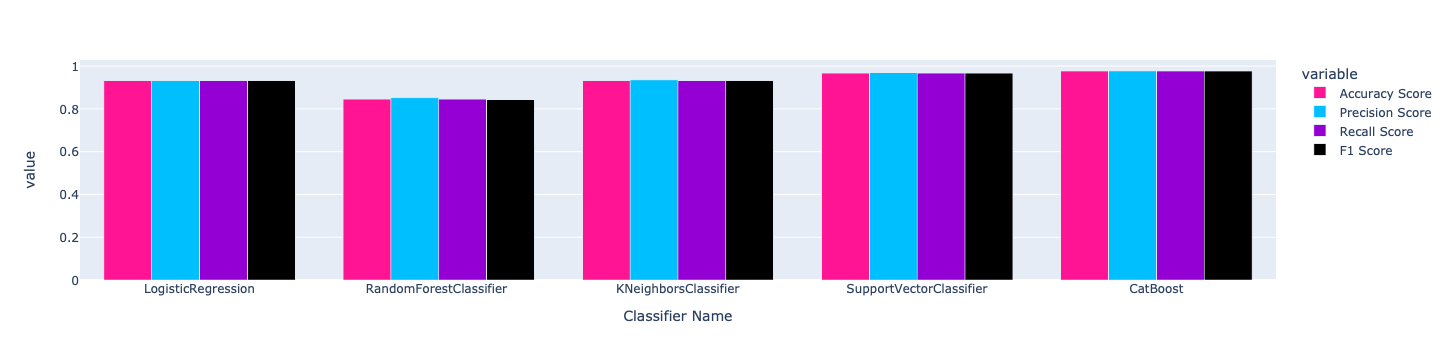

In [41]:
acc_comparison = px.bar(summary_df, x="Classifier Name",
                        y=col_names[1:len(col_names)],
                        color_discrete_sequence=["deeppink",
                                                 "deepskyblue",
                                                 "darkviolet",
                                                 "black"],
                        barmode="group")
acc_comparison.show()

# Application Spark
Spark tend to perform faster when reading from csv compared to using pandas dataframe thus, the X and y df has been made into X and y csv file

In [42]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
conf = SparkConf().setAppName("MyApp").set("spark.executor.cores", "2")


spark = SparkSession.builder.config(conf=conf).getOrCreate()


bash: /home/thuannhan/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/thuannhan/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by bash)
23/07/28 02:14:16 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface enp3s0)
23/07/28 02:14:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/28 02:14:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [43]:
df_shuffle=X

In [44]:
df_shuffle[target]=y

In [45]:
df_shuffle=df_shuffle.sample(frac=1)

In [46]:
df_shuffle

Age  Number of sexual partners  First sexual intercourse  \
1257   28                   1.950237                 18.000000   
136    29                   4.000000                 18.000000   
184    28                   2.000000                 17.000000   
1314   20                   2.000000                 16.947865   
1555   16                   1.167483                 12.837413   
...   ...                        ...                       ...   
1473   18                   1.306318                 17.693682   
1540   25                   3.892605                 15.595070   
426    20                   3.000000                 17.000000   
1066   22                   2.074431                 15.148863   
915    36                   2.000000                 15.567552   

      Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
1257            3.950237     0.0        0.000000             0.000000   
136             3.000000     0.0        0.000000             0.000000   
184             2.000000     0.0        0.000000             0.000000   
1314            3.000000     0.0        0.000000             0.000000   
1555            2.000000     0.0        0.000000             0.000000   
...                  ...     ...             ...                  ...   
1473            1.306318     0.0        0.000000             0.000000   
1540            2.000000     0.0        0.000000             0.000000   
426             2.000000     0.0        0.000000             0.000000   
1066            2.074431     1.0        5.372157             1.305824   
915             3.716224     0.0        0.000000             0.000000   

      Hormonal Contraceptives  Hormonal Contraceptives (years)       IUD  ...  \
1257                 0.049763                         0.024881  0.000000  ...   
136                  1.000000                         1.000000  0.000000  ...   
184                  1.000000                         9.000000  0.000000  ...   
1314                 0.350712                         0.203413  0.649288  ...   
1555                 0.832517                         0.349657  0.000000  ...   
...                       ...                              ...       ...  ...   
1473                 0.693682                         0.693682  0.000000  ...   
1540                 1.000000                         0.826883  0.000000  ...   
426                  1.000000                         0.250000  0.000000  ...   
1066                 1.000000                         6.000000  0.000000  ...   
915                  1.000000                        14.013569  0.283776  ...   

      Dx:Cancer  Dx:CIN  Dx:HPV  Dx  Hinselmann  Schiller  Citology  \
1257          0       0       0   0           0         1         0   
136           0       0       0   0           0         0         0   
184           0       0       0   0           1         1         0   
1314          0       0       0   0           1         1         0   
1555          0       0       0   0           0         0         0   
...         ...     ...     ...  ..         ...       ...       ...   
1473          0       0       0   0           0         1         0   
1540          0       0       0   0           0         1         0   
426           0       0       0   0           0         0         1   
1066          0       0       0   0           0         1         0   
915           0       0       0   0           0         1         0   

      total_std  total_tests  Biopsy  
1257   0.000000            3       1  
136    0.000000            0       0  
184    0.000000            3       1  
1314   0.000000            3       1  
1555   0.000000            1       1  
...         ...          ...     ...  
1473   0.000000            3       1  
1540   0.892605            3       1  
426    0.000000            2       1  
1066   0.000000            2       1  
915    0.000000            2       1  

[1567 rows x 38 columns]

In [47]:
df_spark=spark.createDataFrame(df_shuffle)

In [49]:
model_list=[]
model_list.append(("LogRegression",LogisticRegression_Spark(featuresCol="features", labelCol=target)))
model_list.append(("DecTree",DecisionTreeClassifier_Spark(featuresCol="features", labelCol=target)))
model_list.append(("RandomForrest",RandomForestClassifier_Spark(featuresCol="features", labelCol=target)))
model_list.append(("GBTClassifier",GBTClassifier_Spark(featuresCol="features", labelCol=target)))
model_list.append(("LinearSVC",LinearSVC_Spark(featuresCol="features", labelCol=target)))
model_list.append(("NaiveBayes",NaiveBayes_Spark(featuresCol="features", labelCol=target)))
model_list.append(("FMClassifier",FMClassifier_Spark(featuresCol="features", labelCol=target)))


In [50]:
Assembler=VectorAssembler(inputCols=df_spark.columns[:-1],
                           outputCol='features')
df_spark=Assembler.transform(df_spark)


In [51]:
df_train_test_spark=df_spark.select('features',target)
df_train_test_spark.show()


23/07/28 02:14:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------+
|            features|Biopsy|
+--------------------+------+
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,4,5,...|     1|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     1|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     1|
+--------------------+------+
only showing top 20 rows



In [52]:
import timeit

performance_metrics=['accuracy','precisionByLabel','recallByLabel','f1']
cols_name=['Name']

for  p in performance_metrics:
    cols_name.append(p)
cols_name.append('time(s)')
performance_df_spark = pd.DataFrame(columns = cols_name)


In [53]:
for itteration in range(1):
    #print(itteration)
    #df_shuffle=df_train_test_spark.orderBy(rand())
    trainDF,testDF=df_train_test_spark.randomSplit([0.75,0.25])
    
    #Handle all normal model
    for model in model_list:
        start_time = timeit.default_timer()
        cur_model=model[1]
        cur_model=cur_model.fit(trainDF)
        pred=cur_model.transform(testDF)
        temp = [model[0]]
        
        for p in performance_metrics:
            evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target, metricName=p)
            temp.append(evaluator.evaluate(pred))
            
        end_time=timeit.default_timer()-start_time
        
        temp.append(end_time)
        performance_df_spark.loc[len(performance_df_spark.index)] = temp
        print(cur_model,end_time)
    


LogisticRegressionModel: uid=LogisticRegression_df909fac779d, numClasses=2, numFeatures=37 2.956532611000057
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_43776d1655b6, depth=5, numNodes=19, numClasses=2, numFeatures=37 1.3925645519999534
RandomForestClassificationModel: uid=RandomForestClassifier_3dbaffd70f5c, numTrees=20, numClasses=2, numFeatures=37 1.3436405669999658


23/07/28 02:14:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/28 02:14:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


GBTClassificationModel: uid = GBTClassifier_555d535635bc, numTrees=20, numClasses=2, numFeatures=37 3.482194691000018
LinearSVCModel: uid=LinearSVC_23e5025cd7d8, numClasses=2, numFeatures=37 1.6698906269999725
NaiveBayesModel: uid=NaiveBayes_e19667cae2a3, modelType=multinomial, numClasses=2, numFeatures=37 0.8319027600000481
FMClassificationModel: uid=FMClassifier_d72e72a932f4, numClasses=2, numFeatures=37, factorSize=8, fitLinear=true, fitIntercept=true 2.9263409389999424


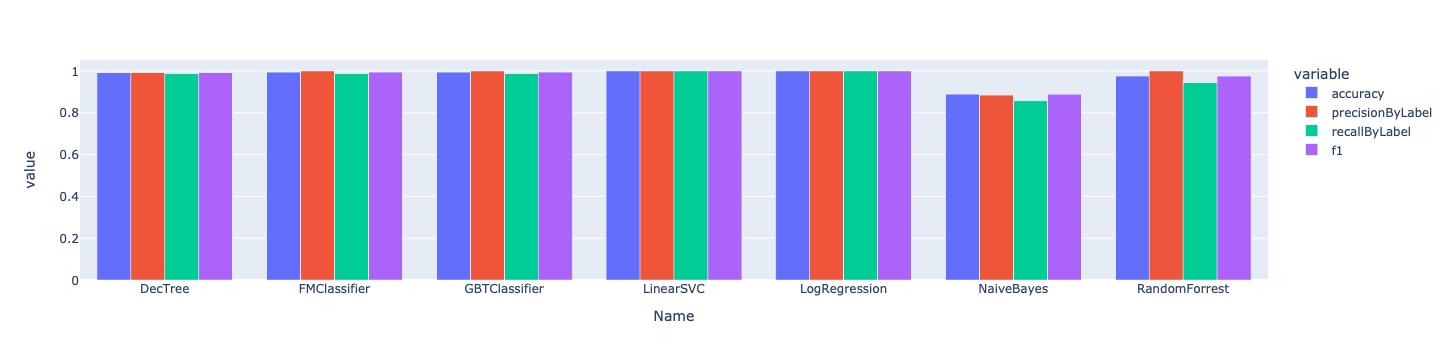

In [54]:
avg_df=performance_df_spark.groupby('Name',as_index=False)[performance_metrics].mean()
acc_comparison = px.bar(avg_df, x="Name",
                        y=performance_metrics,
                        barmode="group")
acc_comparison.show()


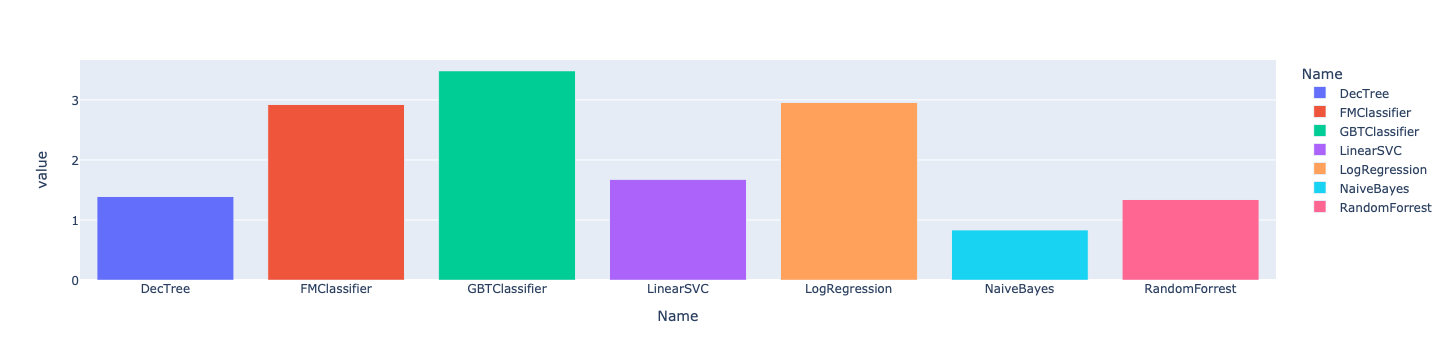

In [55]:
px.bar(performance_df_spark.groupby('Name',as_index=False)['time(s)'].mean(),x="Name",y=["time(s)"],color='Name')


In [56]:
performance_df_spark.groupby('Name',as_index=False).mean()


Name  accuracy  precisionByLabel  recallByLabel        f1  \
0        DecTree  0.991892          0.993750       0.987578  0.991889   
1   FMClassifier  0.994595          1.000000       0.987578  0.994591   
2  GBTClassifier  0.994595          1.000000       0.987578  0.994591   
3      LinearSVC  1.000000          1.000000       1.000000  1.000000   
4  LogRegression  1.000000          1.000000       1.000000  1.000000   
5     NaiveBayes  0.889189          0.884615       0.857143  0.888970   
6  RandomForrest  0.975676          1.000000       0.944099  0.975582   

    time(s)  
0  1.392565  
1  2.926341  
2  3.482195  
3  1.669891  
4  2.956533  
5  0.831903  
6  1.343641

In [57]:
performance_df_spark


Name  accuracy  precisionByLabel  recallByLabel        f1  \
0  LogRegression  1.000000          1.000000       1.000000  1.000000   
1        DecTree  0.991892          0.993750       0.987578  0.991889   
2  RandomForrest  0.975676          1.000000       0.944099  0.975582   
3  GBTClassifier  0.994595          1.000000       0.987578  0.994591   
4      LinearSVC  1.000000          1.000000       1.000000  1.000000   
5     NaiveBayes  0.889189          0.884615       0.857143  0.888970   
6   FMClassifier  0.994595          1.000000       0.987578  0.994591   

    time(s)  
0  2.956533  
1  1.392565  
2  1.343641  
3  3.482195  
4  1.669891  
5  0.831903  
6  2.926341